<a href="https://colab.research.google.com/github/owen198/csc_domain_adaptation/blob/main/csc_autoencoder_da.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn import preprocessing
from sklearn import svm
import pandas as pd
import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
from sklearn import manifold, datasets

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, BatchNormalization, Activation
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras import losses
from keras import metrics
from keras import activations

from sklearn.model_selection import train_test_split

In [2]:
! pip install -q -U keras-tuner
import kerastuner as kt

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# Load data and preprocess

1.   Load data
2.   Divide into normal, abnormal and repaired
3.   



In [4]:
#tag1 = 'W4662FM0507'
#tag2 = 'W4662FM0606'

tag1 = 'W4662FM0400'
tag2 = 'W4662FM0507'
path = './gdrive/My Drive/data/CSC/W4/'

In [5]:
tag1_pd = pd.concat([pd.read_csv(path+tag1+'_202004.csv'),
                       pd.read_csv(path+tag1+'_202005.csv'),
                       pd.read_csv(path+tag1+'_202006.csv'),
                       pd.read_csv(path+tag1+'_202007.csv'),
                       pd.read_csv(path+tag1+'_202008.csv'),
                       pd.read_csv(path+tag2+'_202009.csv')])

tag2_pd = pd.concat([pd.read_csv(path+tag2+'_202009.csv'),
                       pd.read_csv(path+tag2+'_202010.csv'),
                       pd.read_csv(path+tag2+'_202011.csv'),
                       pd.read_csv(path+tag2+'_202012.csv'),
                       pd.read_csv(path+tag2+'_202101.csv'),
                       pd.read_csv(path+tag2+'_202102.csv')])

In [6]:
tag1_pd['datetime'] = tag1_pd['timestamp'].astype('int').astype("datetime64[s]")
tag2_pd['datetime'] = tag2_pd['timestamp'].astype('int').astype("datetime64[s]")

In [93]:
#tag1_normal = tag1_pd[(tag1_pd['datetime'] > datetime.datetime(2020,9,1,0,0)) & (tag1_pd['datetime'] < datetime.datetime(2021,1,8,0,0))]
#tag1_abnormal = tag1_pd[(tag1_pd['datetime'] > datetime.datetime(2021,1,9,0,0)) & (tag1_pd['datetime'] < datetime.datetime(2021,2,1,0,0))]

tag1_normal = tag1_pd[(tag1_pd['datetime'] > datetime.datetime(2020,4,1,0,0)) & (tag1_pd['datetime'] < datetime.datetime(2020,6,14,0,0))]
tag1_abnormal = tag1_pd[(tag1_pd['datetime'] > datetime.datetime(2020,6,15,0,0)) & (tag1_pd['datetime'] < datetime.datetime(2020,6,27,0,0))]

tag2_normal = tag2_pd[(tag2_pd['datetime'] > datetime.datetime(2020,9,1,0,0)) & (tag2_pd['datetime'] < datetime.datetime(2021,1,8,0,0))]
tag2_abnormal = tag2_pd[(tag2_pd['datetime'] > datetime.datetime(2021,1,9,0,0)) & (tag2_pd['datetime'] < datetime.datetime(2021,2,1,0,0))]

In [94]:
tag1_normal = tag1_normal.sort_values('datetime')
tag1_abnormal = tag1_abnormal.sort_values('datetime')

tag2_normal = tag2_normal.sort_values('datetime')
tag2_abnormal = tag2_abnormal.sort_values('datetime')

In [95]:
#list(target_repaired)

tag1_normal_dt = tag1_normal['datetime']
tag1_abnormal_dt = tag1_abnormal['datetime']

tag2_normal_dt = tag2_normal['datetime']
tag2_abnormal_dt = tag2_abnormal['datetime']
'''
original_list = [s for s in list(tag1_normal) if (s.startswith('CREST') or 
                                                      s.startswith('KURT_') or 
                                                      s.startswith('SKEW') or 
                                                      s.startswith('RMS_'))]

tag1_normal = tag1_normal[original_list]
tag1_abnormal = tag1_abnormal[original_list]

tag2_normal = tag2_normal[original_list]
tag2_abnormal = tag2_abnormal[original_list]
'''

"\noriginal_list = [s for s in list(tag1_normal) if (s.startswith('CREST') or \n                                                      s.startswith('KURT_') or \n                                                      s.startswith('SKEW') or \n                                                      s.startswith('RMS_'))]\n\ntag1_normal = tag1_normal[original_list]\ntag1_abnormal = tag1_abnormal[original_list]\n\ntag2_normal = tag2_normal[original_list]\ntag2_abnormal = tag2_abnormal[original_list]\n"

In [96]:

drop_list = ['Unnamed: 0', '_id','type','scada','timestamp','device', 'datetime']

tag1_normal = tag1_normal.drop(columns=drop_list)
tag1_abnormal = tag1_abnormal.drop(columns=drop_list)


tag2_normal = tag2_normal.drop(columns=drop_list)
tag2_abnormal = tag2_abnormal.drop(columns=drop_list)



# Define Target and Source

In [97]:
import random

shape_min = min (tag1_normal.shape[0], tag2_normal.shape[0])
shape_max = max (tag1_normal.shape[0], tag2_normal.shape[0])

index = sorted(random.sample(range(0, shape_max), shape_min))

In [98]:
X_source = tag1_normal
X_target = tag2_normal

X_source_ab = tag1_abnormal
X_target_ab = tag2_abnormal

X_source_dt = tag1_normal_dt
X_target_dt = tag2_normal_dt

X_source_ab_dt = tag1_abnormal_dt
X_target_ab_dt = tag2_abnormal_dt

In [99]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler = min_max_scaler.fit(X_source)

X_source = pd.DataFrame(min_max_scaler.transform(X_source))
X_target = pd.DataFrame(min_max_scaler.transform(X_target))

X_source_ab = pd.DataFrame(min_max_scaler.transform(X_source_ab))
X_target_ab = pd.DataFrame(min_max_scaler.transform(X_target_ab))

#target_normal = pd.DataFrame(min_max_scaler.transform(target_normal))
#target_abnormal = pd.DataFrame(min_max_scaler.transform(target_abnormal))

# OneClass SVM cross-validation

In [100]:
model_source = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01).fit(X_source)
model_target = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01).fit(X_target)

In [101]:
def scorer_(Y_pred):
    a = (Y_pred[Y_pred == -1].size)/(Y_pred.size)
    return a*100

In [102]:
def plot_score (score_list, date_list, tag):

    fig, ax = plt.subplots(figsize=(10, 2))
    plt.xticks(rotation=45)
    ax.plot(date_list, score_list, 'o-')
    ax.set(xlabel='date', ylabel='score', title=tag)
    ax.grid()
    plt.ylim(0, 100)
    #fig.savefig(path+tag+'-'+training_from.strftime("%Y%m%d")+'-'+training_to.strftime("%Y%m%d")+'.png', dpi=300)
    plt.show()

In [103]:
def get_score_list(normal_df, abnormal_df, normal_df_dt, abnormal_df_dt, model):

    score_list = []
    date_list = []
    delta = datetime.timedelta(days=1)

    validation_df = normal_df.append(abnormal_df)
    validation_df_dt = normal_df_dt.append(abnormal_df_dt)
    validation_df['datetime'] = validation_df_dt.values

    # calculation duration
    start_date = validation_df.head(1)['datetime'].values[0]
    end_date = validation_df.tail(1)['datetime'].values[0]
    start_date = datetime.datetime.fromtimestamp(start_date.astype('datetime64[s]').astype('int'))
    end_date = datetime.datetime.fromtimestamp(end_date.astype('datetime64[s]').astype('int'))
    
    while start_date <= end_date:
        validation_sub_df = validation_df[(validation_df['datetime'] > start_date) & (validation_df['datetime'] < start_date + delta)]

        if len(validation_sub_df) > 0:

            validation_df_sc = model.predict(validation_sub_df.drop(columns=['datetime']))
            score_list.append(scorer_(validation_df_sc))
            date_list.append(start_date)

        start_date += delta
        
    return score_list, date_list

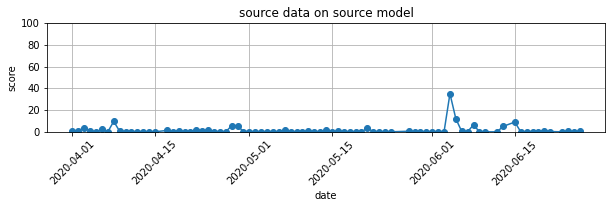

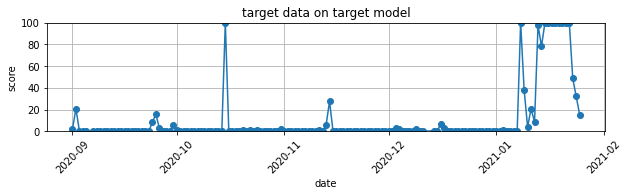

In [104]:
source_score, source_date = get_score_list(X_source, 
                                           X_source_ab, 
                                           X_source_dt, 
                                           X_source_ab_dt, 
                                           model_source)

plot_score (source_score, source_date, 'source data on source model')

target_score, target_date = get_score_list(X_target, 
                                           X_target_ab, 
                                           X_target_dt, 
                                           X_target_ab_dt, 
                                           model_target)

plot_score (target_score, target_date, 'target data on target model')

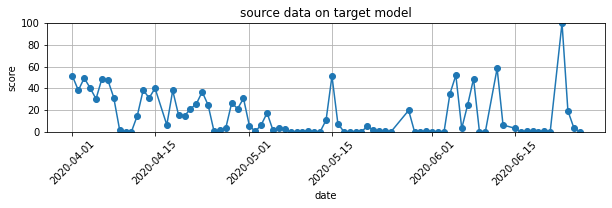

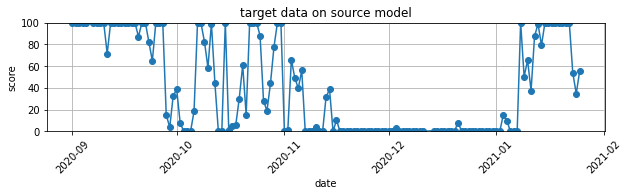

In [105]:
source_score_cv, source_date_cv = get_score_list(X_source, 
                                           X_source_ab, 
                                           X_source_dt, 
                                           X_source_ab_dt,  
                                           model_target)

plot_score (source_score_cv, source_date_cv, 'source data on target model')

target_score_cv, target_date_cv = get_score_list(X_target, 
                                           X_target_ab, 
                                           X_target_dt, 
                                           X_target_ab_dt, 
                                           model_source)

plot_score (target_score_cv, target_date_cv, 'target data on source model')

## Autoencoder

In [106]:
! rm -rf ./untitle*

In [107]:
def autoencoder (hp):

    input_dim = X_source.shape[1]

    hp_dim1 = hp.Int('units_1', min_value=64, max_value=96, step=4)
    hp_dim2 = hp.Int('units_2', min_value=64, max_value=80, step=4)
    hp_dim3 = hp.Int('units_3', min_value=48, max_value=64, step=4)
    hp_bottleneck_dim = hp.Int('units_b', min_value=2, max_value=16, step=4)
    hp_activation_h = hp.Choice('activation_h', values=['elu', 'selu'])
    hp_activation_o = hp.Choice('activation_o', values=['sigmoid', 'softmax'])

    input_img = Input(shape=(input_dim,))

    x = Dense(units=hp_dim1)(input_img)
    x = BatchNormalization()(x)
    x = Activation(hp_activation_h)(x)
    x = Dense(units=hp_dim2)(x)
    x = BatchNormalization()(x)
    x = Activation(hp_activation_h)(x)
    x = Dense(units=hp_dim3)(x)
    x = BatchNormalization()(x)
    x = Activation(hp_activation_h)(x)

    encoded = Dense(units=hp_bottleneck_dim)(x)
    encoded = BatchNormalization()(encoded)
    encoded = Activation(hp_activation_h)(encoded)

    x = Dense(units=hp_dim3)(encoded)
    x = BatchNormalization()(x)
    x = Activation(hp_activation_h)(x)
    x = Dense(units=hp_dim2)(encoded)
    x = BatchNormalization()(x)
    x = Activation(hp_activation_h)(x)
    x = Dense(units=hp_dim1)(x)
    x = BatchNormalization()(x)
    x = Activation(hp_activation_h)(x)

    decoded = Dense(units=input_dim)(x)
    encoded = Activation(hp_activation_o)(encoded)

    autoencoder = Model(input_img, decoded)
    autoencoder.summary() 
    encoder = Model(input_img, encoded)

    #decoder_input = Input(shape=(hp_bottleneck_dim,))
    #decoder_layer = autoencoder.layers[-3](decoder_input)
    #decoder_layer = autoencoder.layers[-2](decoder_layer)
    #decoder_layer = autoencoder.layers[-1](decoder_layer)
    #decoder = Model(decoder_input, decoder_layer)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-4, 1e-6])
    hp_loss = hp.Choice('loss', values=['mean_absolute_error', 'mean_absolute_percentage_error'])

    autoencoder.compile(loss = hp_loss, 
                        optimizer = optimizers.Adam(lr=hp_learning_rate),
                        metrics=[metrics.RootMeanSquaredError()])
    
    return autoencoder


In [108]:
tuner = kt.Hyperband(autoencoder,
                     objective='loss',
                     max_epochs=20)

early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=2)

if len(X_target) > len(X_source):
    X = X_target.iloc[index]
    Y = X_source
else:
    X = X_target
    Y = X_source.iloc[index]

tuner.search(X, Y, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Trial 30 Complete [00h 02m 12s]
loss: 19429.564453125

Best loss So Far: 0.05567122623324394
Total elapsed time: 00h 24m 28s
INFO:tensorflow:Oracle triggered exit


In [109]:
tuner.get_best_models(num_models=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 390)]             0         
_________________________________________________________________
dense (Dense)                (None, 72)                28152     
_________________________________________________________________
batch_normalization (BatchNo (None, 72)                288       
_________________________________________________________________
activation (Activation)      (None, 72)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 72)                5256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 72)                288       
_________________________________________________________________
activation_1 (Activation)    (None, 72)                0     

In [110]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
autoencoder = tuner.hypermodel.build(best_hps)
model = autoencoder.fit(Y, # Source
                        X, # Target
                        validation_split=0.2,
                        epochs=500, 
                        batch_size=128, 
                        callbacks = early_stopping,
                        verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 390)]             0         
_________________________________________________________________
dense (Dense)                (None, 72)                28152     
_________________________________________________________________
batch_normalization (BatchNo (None, 72)                288       
_________________________________________________________________
activation (Activation)      (None, 72)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 72)                5256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 72)                288       
_________________________________________________________________
activation_1 (Activation)    (None, 72)                0     

In [111]:
'''
input_dim = X_source.shape[1]

encoder_dim_1 = 512
encoder_dim_2 = 256
bottleneck_dim = 4
decoder_dim_1 = 64
decoder_dim_2 = 128

input_img = Input(shape=(input_dim,))

x = Dense(units=512)(input_img)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Dense(units=256)(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)

encoded = Dense(units=2)(x)
encoded = BatchNormalization()(encoded)

x = Dense(units=256)(encoded)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Dense(units=512)(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)

decoded = Dense(units=input_dim)(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary() 
encoder = Model(input_img, encoded)

decoder_input = Input(shape=(bottleneck_dim,))
decoder_layer = autoencoder.layers[-3](decoder_input)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)
decoder = Model(decoder_input, decoder_layer)
'''

"\ninput_dim = X_source.shape[1]\n\nencoder_dim_1 = 512\nencoder_dim_2 = 256\nbottleneck_dim = 4\ndecoder_dim_1 = 64\ndecoder_dim_2 = 128\n\ninput_img = Input(shape=(input_dim,))\n\nx = Dense(units=512)(input_img)\nx = BatchNormalization()(x)\nx = Activation('elu')(x)\nx = Dense(units=256)(x)\nx = BatchNormalization()(x)\nx = Activation('elu')(x)\n\nencoded = Dense(units=2)(x)\nencoded = BatchNormalization()(encoded)\n\nx = Dense(units=256)(encoded)\nx = BatchNormalization()(x)\nx = Activation('elu')(x)\nx = Dense(units=512)(x)\nx = BatchNormalization()(x)\nx = Activation('elu')(x)\n\ndecoded = Dense(units=input_dim)(x)\n\nautoencoder = Model(input_img, decoded)\nautoencoder.summary() \nencoder = Model(input_img, encoded)\n\ndecoder_input = Input(shape=(bottleneck_dim,))\ndecoder_layer = autoencoder.layers[-3](decoder_input)\ndecoder_layer = autoencoder.layers[-2](decoder_layer)\ndecoder_layer = autoencoder.layers[-1](decoder_layer)\ndecoder = Model(decoder_input, decoder_layer)\n"

In [112]:
'''
if len(X_target) > len(X_source):
    X = X_target.iloc[index]
    Y = X_source
else:
    X = X_target
    Y = X_source.iloc[index]
'''

'\nif len(X_target) > len(X_source):\n    X = X_target.iloc[index]\n    Y = X_source\nelse:\n    X = X_target\n    Y = X_source.iloc[index]\n'

In [113]:
'''
opt=optimizers.Adam(lr=0.000001)

autoencoder.compile(loss=losses.mean_squared_error, 
                    optimizer='Adam')


early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=2)
# 訓練模型
model = autoencoder.fit(X, 
                        Y,
                        validation_split=0.2,
                        epochs=100, 
                        batch_size=256, 
                        callbacks = early_stopping,
                        verbose=1)
'''

#encoded_imgs = encoder.predict(X_source)
#decoded_imgs = decoder.predict(encoded_imgs)

decoded_imgs = autoencoder.predict(X_source)

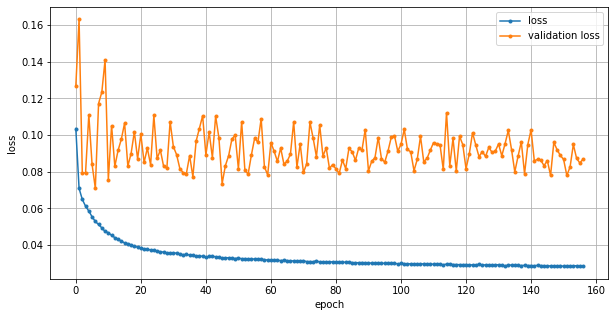

In [114]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(model.history['loss'], marker='.', label='loss')
ax.plot(model.history['val_loss'], marker='.', label='validation loss')

ax.legend()
ax.grid(True)

plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('epoches.png', dpi=300)
plt.show()

#model.history.keys()

In [115]:
#print('original dist:', np.linalg.norm(X_source-X_target.sample(n=15017)))
#print('domain adaptation:', np.linalg.norm(decoded_imgs - X_target.sample(n=15017)))

In [116]:
from sklearn.decomposition import PCA

pca_scale = PCA(n_components=2)
pca_scale = pca_scale.fit(X_source)

X_source_dr = pca_scale.transform(X_source)
x_min, x_max = X_source_dr.min(0), X_source_dr.max(0)
X_norm = (X_source_dr-x_min) / (x_max-x_min)  #Normalize
X_source_df = pd.DataFrame(X_norm, columns = ['dim1','dim2'])

X_target_dr = pca_scale.transform(X_target)
x_min, x_max = X_target_dr.min(0), X_target_dr.max(0)
X_norm = (X_target_dr-x_min) / (x_max-x_min)  #Normalize
X_target_df = pd.DataFrame(X_norm, columns = ['dim1','dim2'])

X_decoder_dr = pca_scale.transform(decoded_imgs)
x_min, x_max = X_decoder_dr.min(0), X_decoder_dr.max(0)
X_norm = (X_decoder_dr-x_min) / (x_max-x_min)  #Normalize
X_decode_df = pd.DataFrame(X_norm, columns = ['dim1','dim2'])

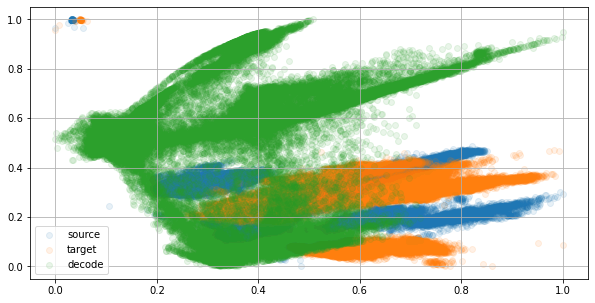

In [117]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(X_source_df['dim1'], X_source_df['dim2'], alpha=0.1, label='source')
ax.scatter(X_target_df['dim1'], X_target_df['dim2'], alpha=0.1, label='target')
ax.scatter(X_decode_df['dim1'], X_decode_df['dim2'], alpha=0.1, label='decode')

ax.legend()
ax.grid(True)

#plt.ylim(0, 1)
#plt.xlim(0, 1)
plt.savefig('distribution.png', dpi=300)
plt.show()

In [118]:
'''
source_encode = encoder.predict(X_source)
target_encode = encoder.predict(X_target)

target_decode = decoder.predict(target_encode)
source_decode = decoder.predict(source_encode)
'''

'\nsource_encode = encoder.predict(X_source)\ntarget_encode = encoder.predict(X_target)\n\ntarget_decode = decoder.predict(target_encode)\nsource_decode = decoder.predict(source_encode)\n'

In [119]:
# test bottleneck layer
'''
model_encode = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01).fit(target_encode)

pred_source = scorer_(model_encode.predict(source_encode))
pred_target = scorer_(model_encode.predict(target_encode))

print('source:', pred_source, 'target:', pred_target)
'''

'\nmodel_encode = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01).fit(target_encode)\n\npred_source = scorer_(model_encode.predict(source_encode))\npred_target = scorer_(model_encode.predict(target_encode))\n\nprint(\'source:\', pred_source, \'target:\', pred_target)\n'

In [120]:
# test decode layer
source_decode = decoded_imgs

model_decode = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01).fit(source_decode)
'''
pred_source = scorer_(model_decode.predict(source_decode))
pred_target = scorer_(model_decode.predict(target_decode))

print('source:', pred_source, 'target:', pred_target)
'''

"\npred_source = scorer_(model_decode.predict(source_decode))\npred_target = scorer_(model_decode.predict(target_decode))\n\nprint('source:', pred_source, 'target:', pred_target)\n"

In [121]:
# test target model
'''
pred_target_by_target = scorer_(model_target.predict(X_target))
pred_target_by_source = scorer_(model_decode.predict(X_target))
print('without any intervention:', pred_target_by_target, pred_target_by_source)
'''

"\npred_target_by_target = scorer_(model_target.predict(X_target))\npred_target_by_source = scorer_(model_decode.predict(X_target))\nprint('without any intervention:', pred_target_by_target, pred_target_by_source)\n"

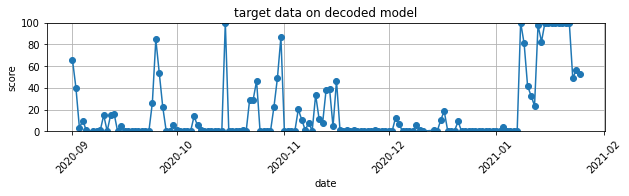

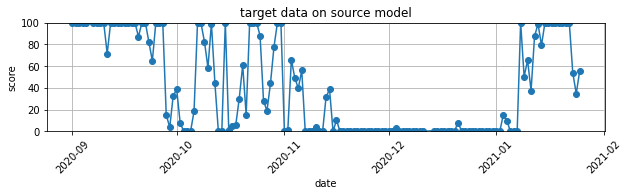

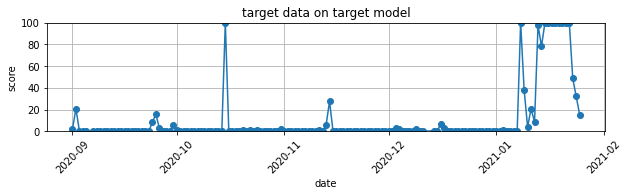

In [125]:
target_score_da, target_date_da = get_score_list(X_target, 
                                           X_target_ab, 
                                           X_target_dt, 
                                           X_target_ab_dt, 
                                           model_decode)

plot_score (target_score_da, target_date_da, 'target data on decoded model')

target_score_cv, target_date_cv = get_score_list(X_target, 
                                           X_target_ab, 
                                           X_target_dt, 
                                           X_target_ab_dt, 
                                           model_source)

plot_score (target_score_cv, target_date_cv, 'target data on source model')

target_score, target_date = get_score_list(X_target, 
                                           X_target_ab, 
                                           X_target_dt, 
                                           X_target_ab_dt, 
                                           model_target)

plot_score (target_score, target_date, 'target data on target model')

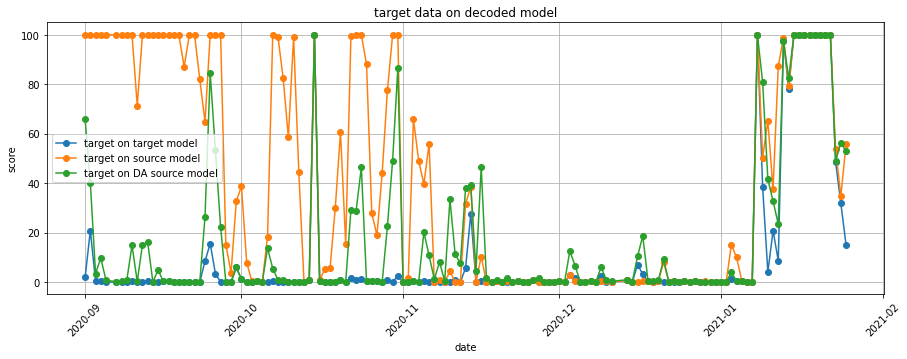

In [123]:

fig, ax = plt.subplots(figsize=(15, 5))
plt.xticks(rotation=45)
ax.plot(target_date, target_score, 'o-', label='target on target model')
ax.plot(target_date_cv, target_score_cv, 'o-', label='target on source model')
ax.plot(target_date_da, target_score_da, 'o-', label='target on DA source model')

ax.set(xlabel='date', ylabel='score', title='target data on decoded model')

ax.legend()
ax.grid()
#fig.savefig(path+tag+'-'+training_from.strftime("%Y%m%d")+'-'+training_to.strftime("%Y%m%d")+'.png', dpi=300)
plt.show()